<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bambi-notebook)=
# Zucchero sintattico

I modelli lineari sono utilizzati così ampiamente che sono stati sviluppati appositamente una sintassi, dei metodi e delle librerie per la regressione. Una di queste librerie è `bambi` (BAyesian Model-Building Interface). `bambi` è un pacchetto Python per adattare modelli gerarchici generalizzati lineari (di cui il modello lineaere bivariato è un caso particolare), utilizzando una sintassi simile a quella che si trova nei pacchetti R, come `lme4`, `nlme`, `rstanarm` o `brms`. `bambi` è basato su PyMC ma fornisce un'API di più alto livello. 

In questo capitolo vedremo come svolgere l'analisi di regressione usando `bambi` anziché PyMC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
import xarray as xr
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-veridish")

Simuliamo i dati esattamente come abbiamo fatto nel capitolo precedente.

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

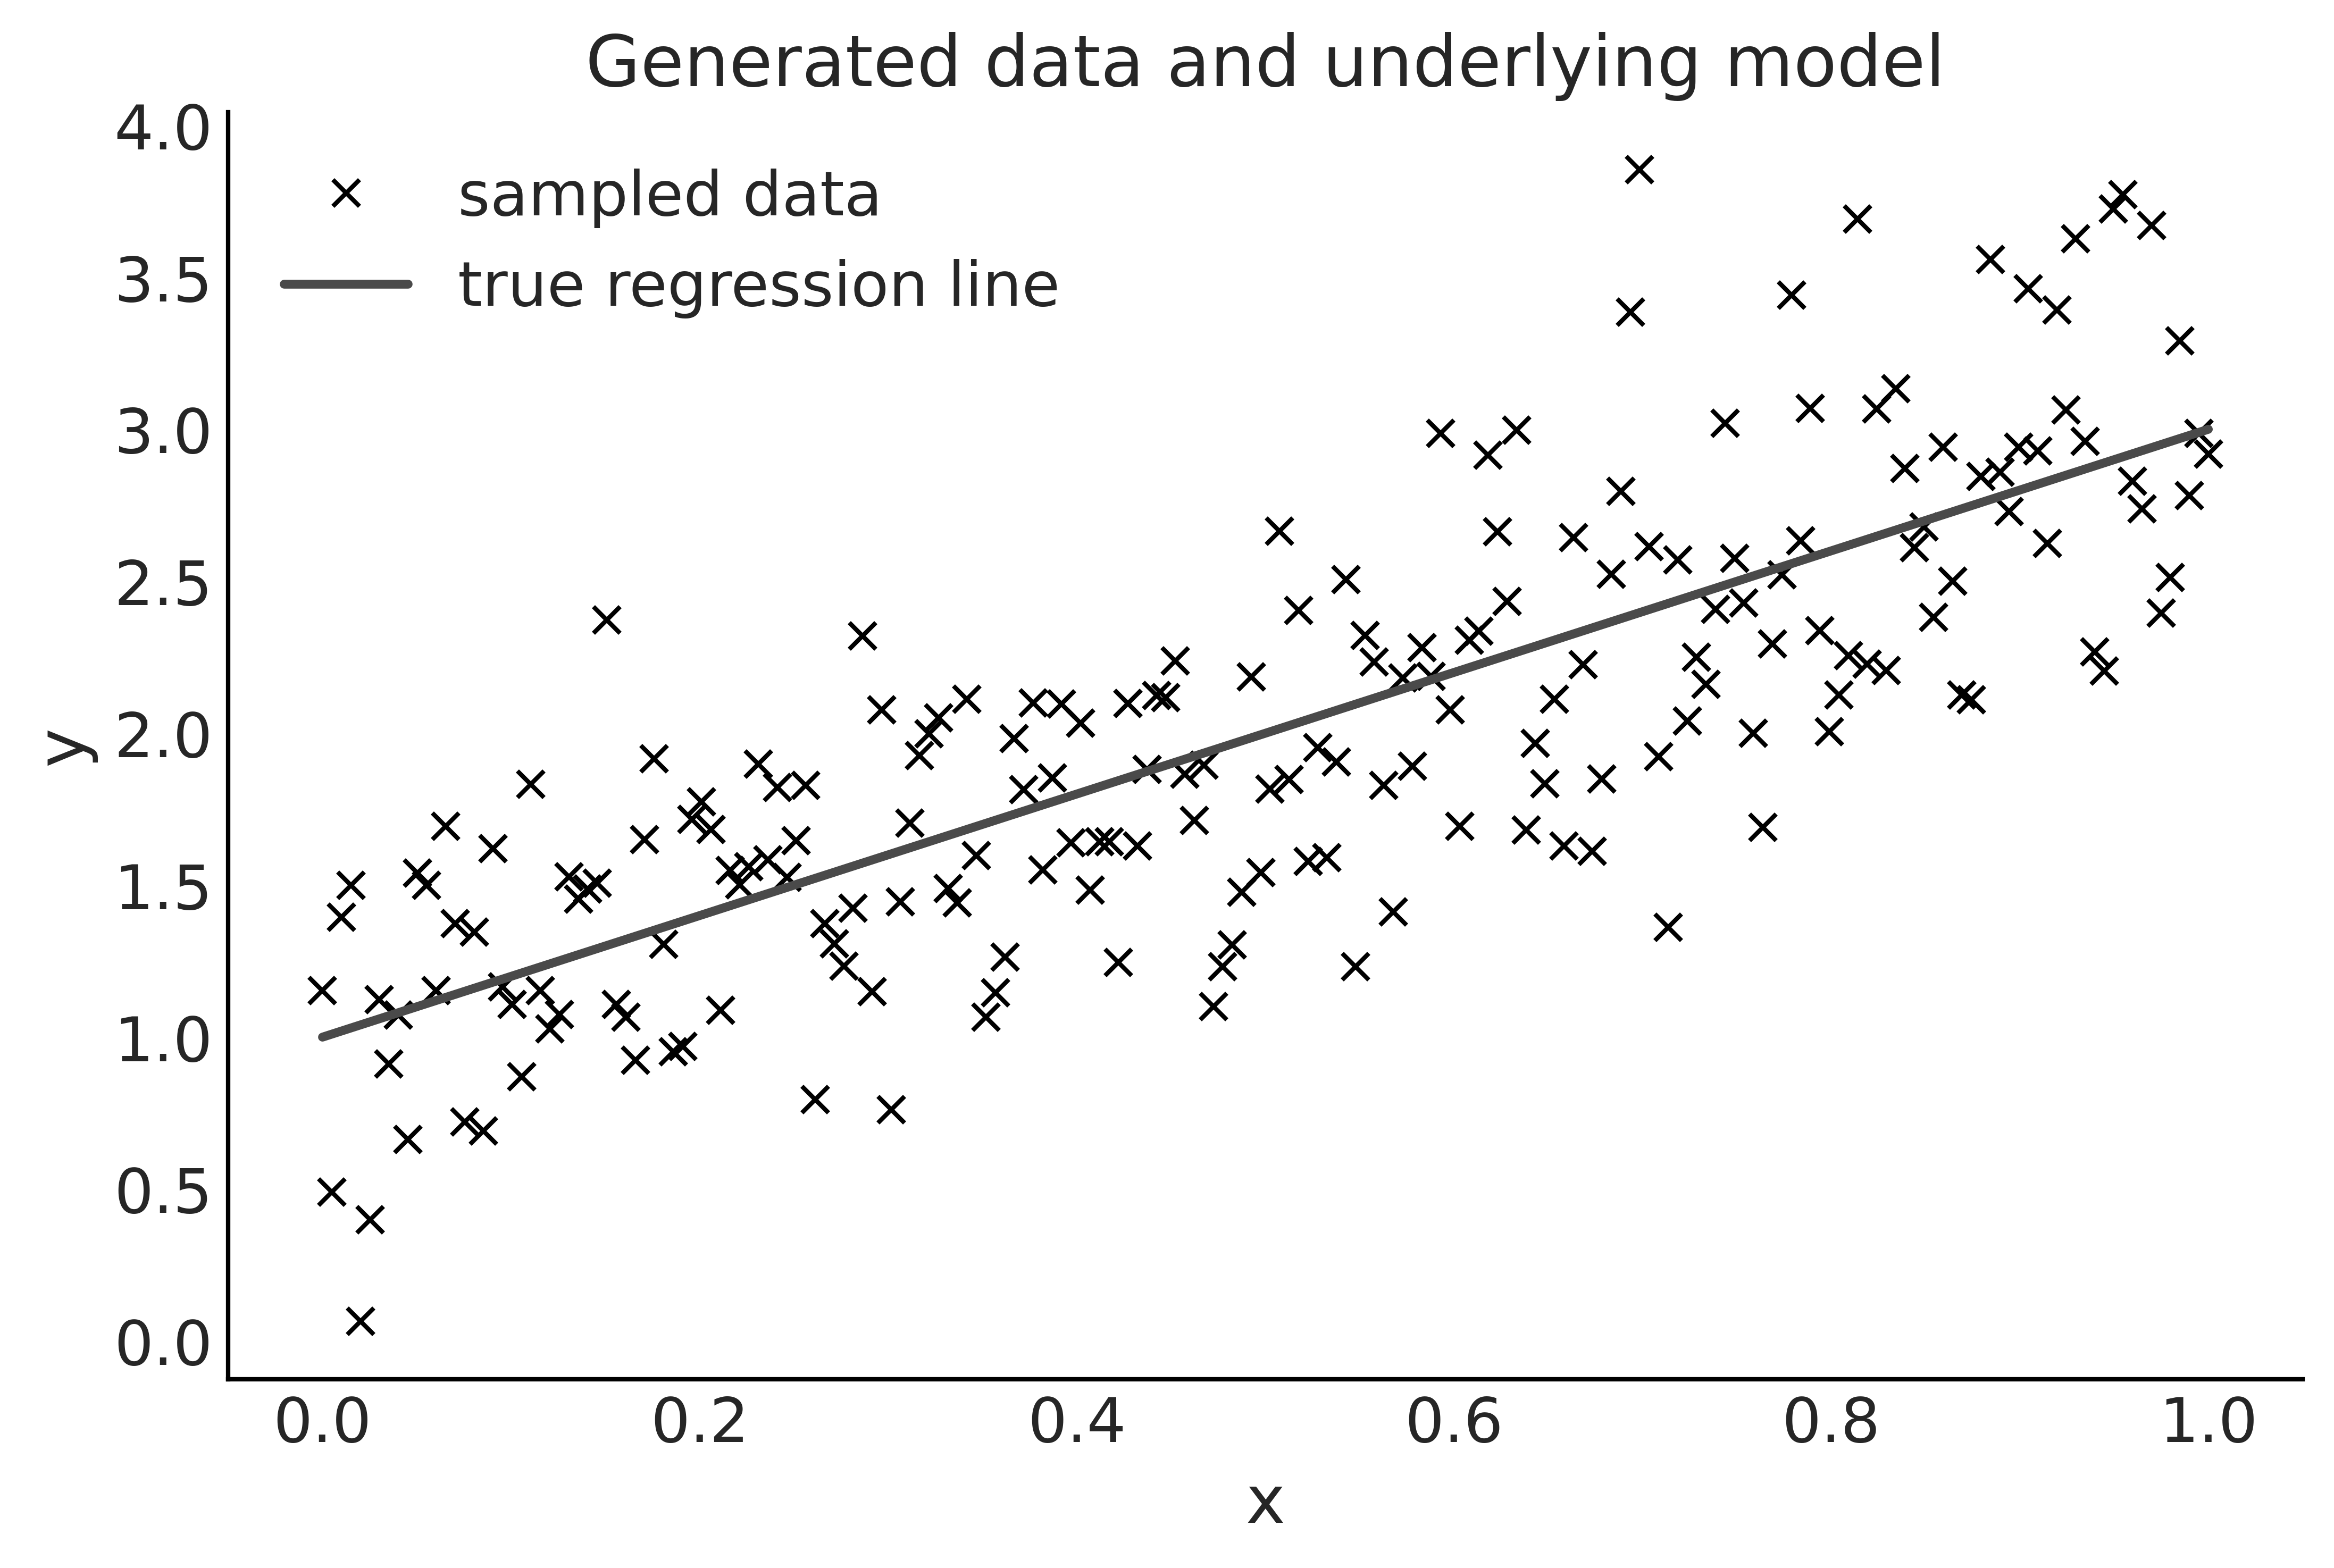

In [4]:
plt.plot(x, y, "x", label="sampled data")
plt.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated data and underlying model")
plt.legend(loc=0);

Per replicare il modello descritto nel capitolo {ref}`reglin-pymc-notebook`, possiamo utilizzare la seguente istruzione. La specificazione del modello è facilitata dall'adozione della notazione di Wilkinson {cite:p}`wilkinson1973symbolic`. Inoltre, `bambi` implementa delle distribuzioni a priori ottimizzate, eliminando così la necessità di definirle esplicitamente. Tuttavia, se si preferisce un maggiore controllo sulle distribuzioni a priori, è possibile specificarle manualmente.

In [5]:
model = bmb.Model("y ~ x", data)

Eseguiamo il campionamento MCMC.

In [6]:
idata = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:03.898317
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 552.16it/s]


Sampling time =  0:00:04.101506
Transforming variables...
Transformation time =  0:00:00.033193
Computing Log Likelihood...
Log Likelihood time =  0:00:00.483408


Le distribuzioni a posteriori dei parametri e i trace plot si ottengono con la seguente istruzione.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_19854/3246199967.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


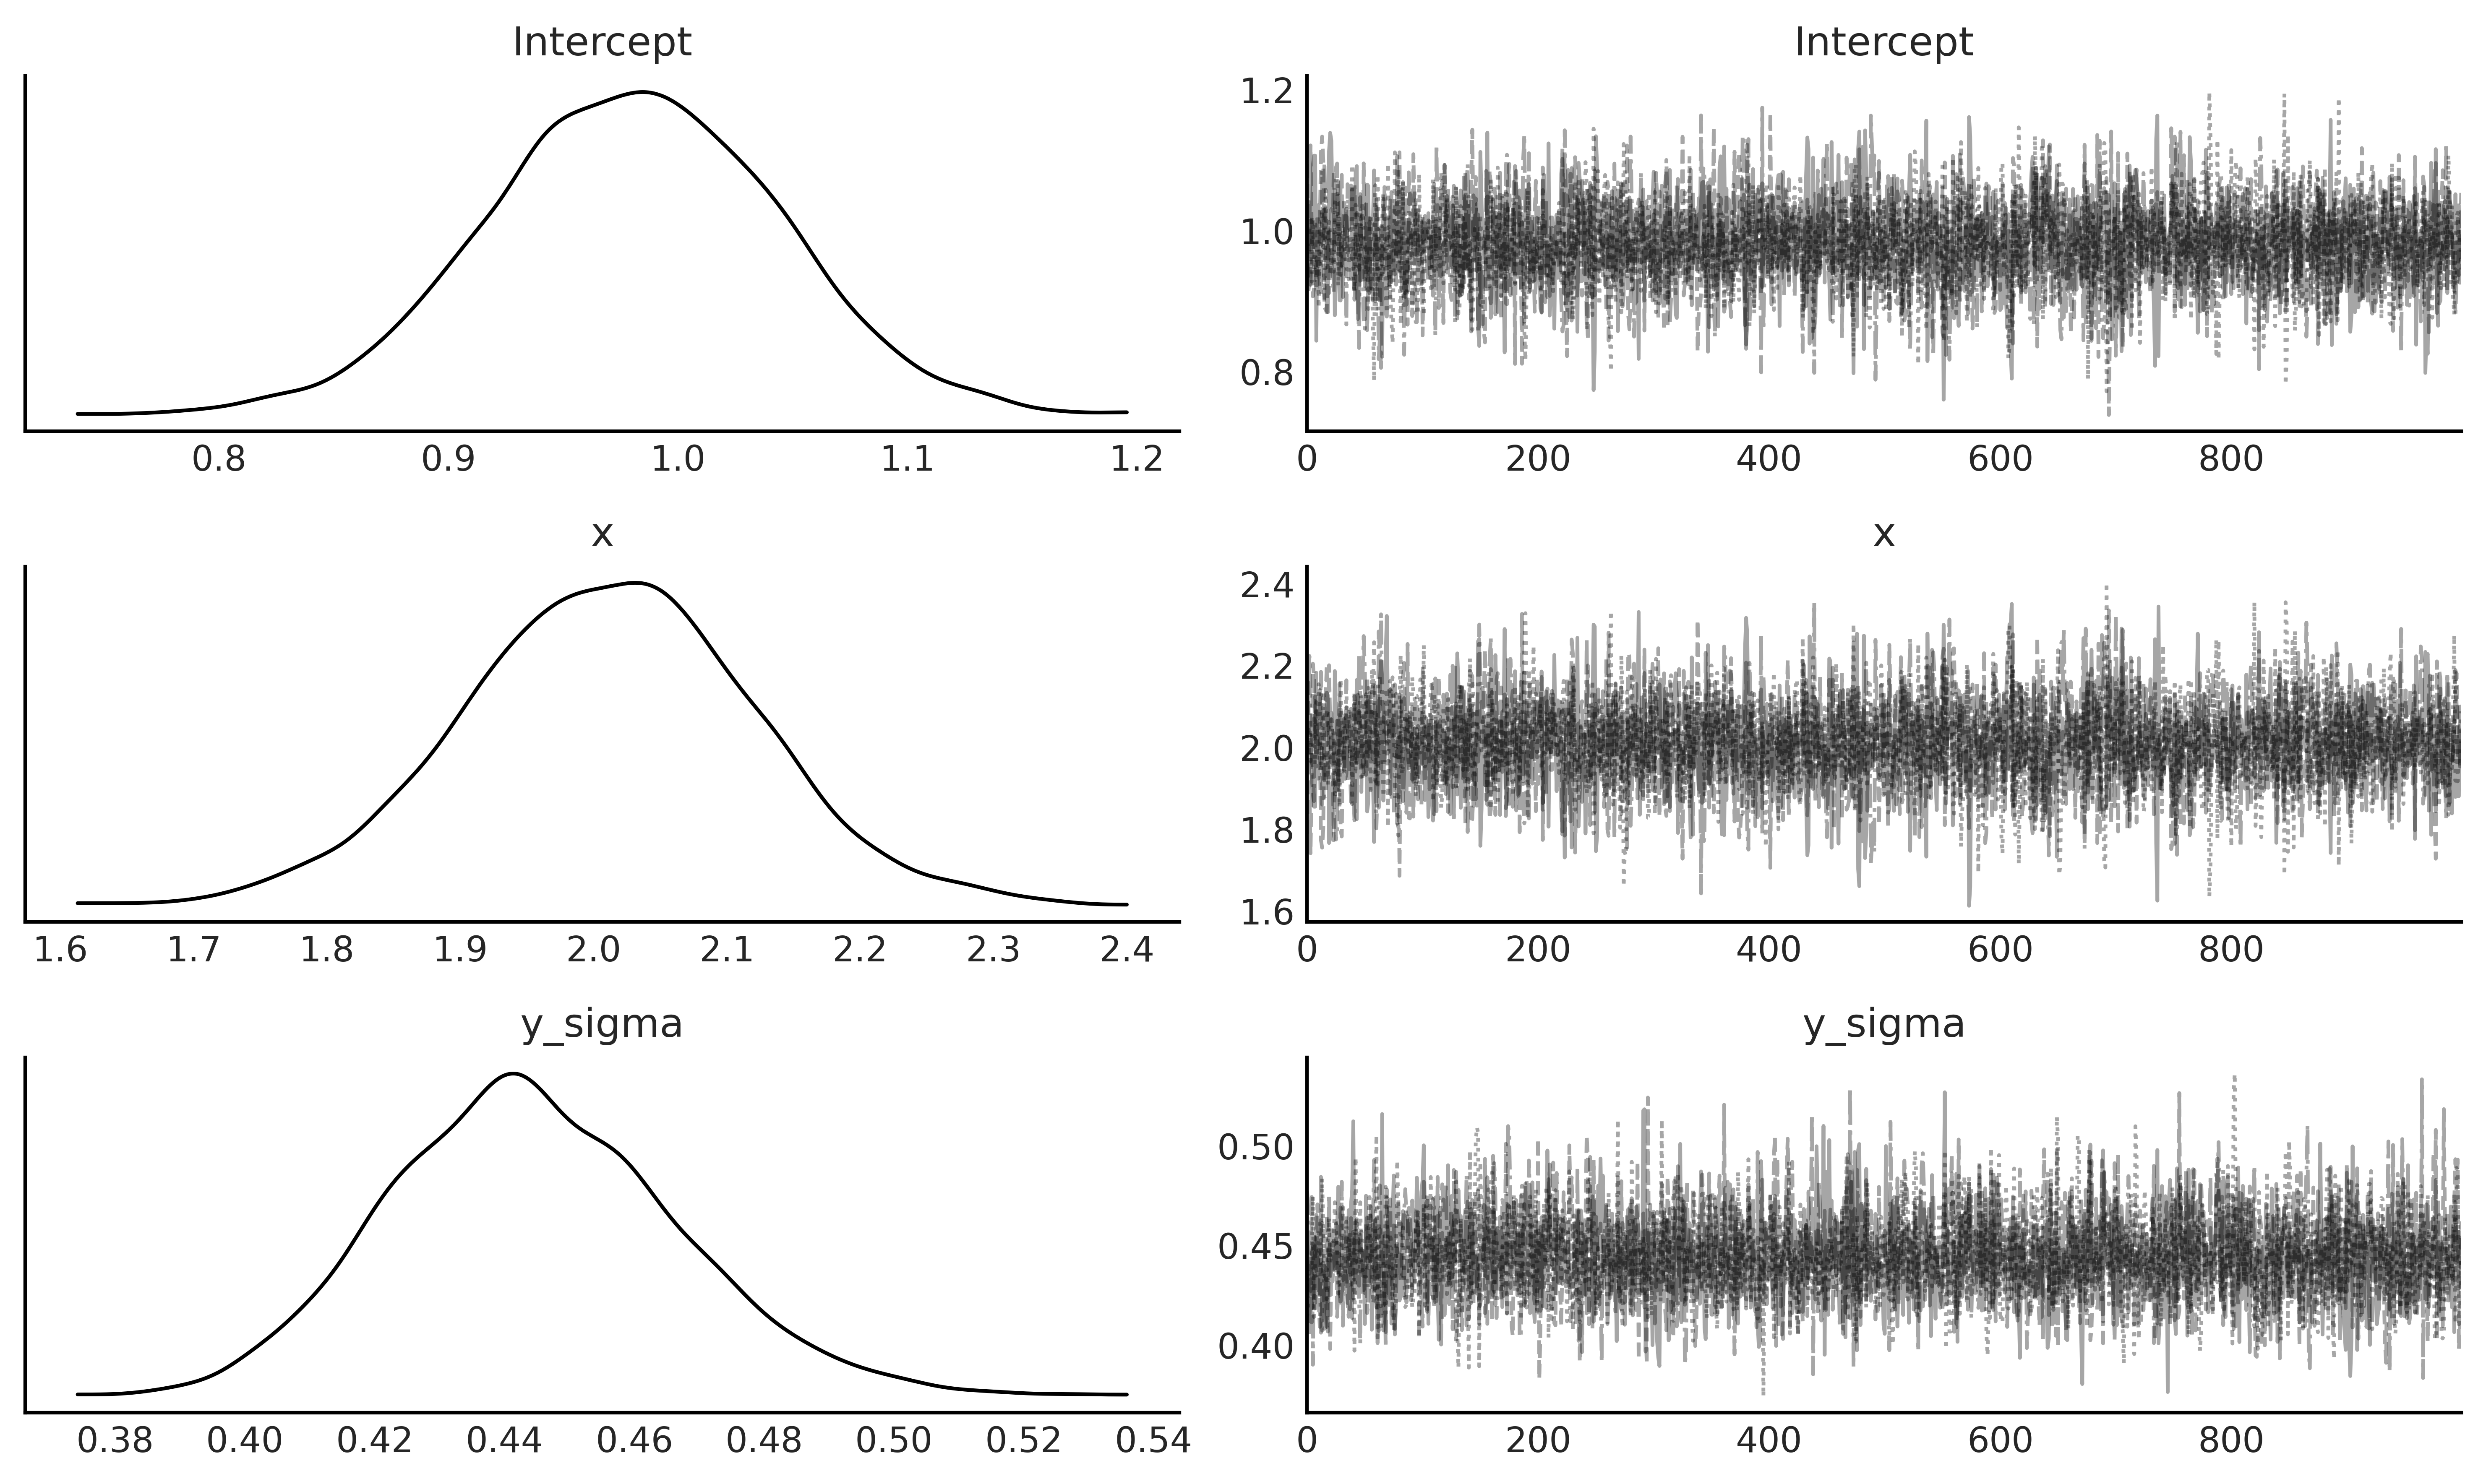

In [9]:
az.plot_trace(idata, combined=True, figsize=(10, 6))
plt.tight_layout();

Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [8]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.98,0.06,0.87,1.10,0.0,0.0,3931.38,2752.78,1.0
x,2.01,0.11,1.80,2.20,0.0,0.0,4094.37,2839.21,1.0
y_sigma,0.44,0.02,0.40,0.49,0.0,0.0,4654.19,2790.18,1.0


Si noti che i risultati replicano quelli ottenuti con PyMC.

Anche in questo caso è posibile generare un grafico che descrive l'incertezza a posteriori delle predizioni del modello. Un grafico predittivo a posteriori estrae più campioni dalla distribuzione a posteriori (intercette e pendenze) e traccia una retta di regressione per ciascuno di essi. Possiamo generare manualmente queste rette di regressione utilizzando direttamente i campioni a posteriori con l'istruzione seguente. Si noti che, usando `bambi`, il parametro $\alpha$ è denominato `Intercept`.

In [9]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


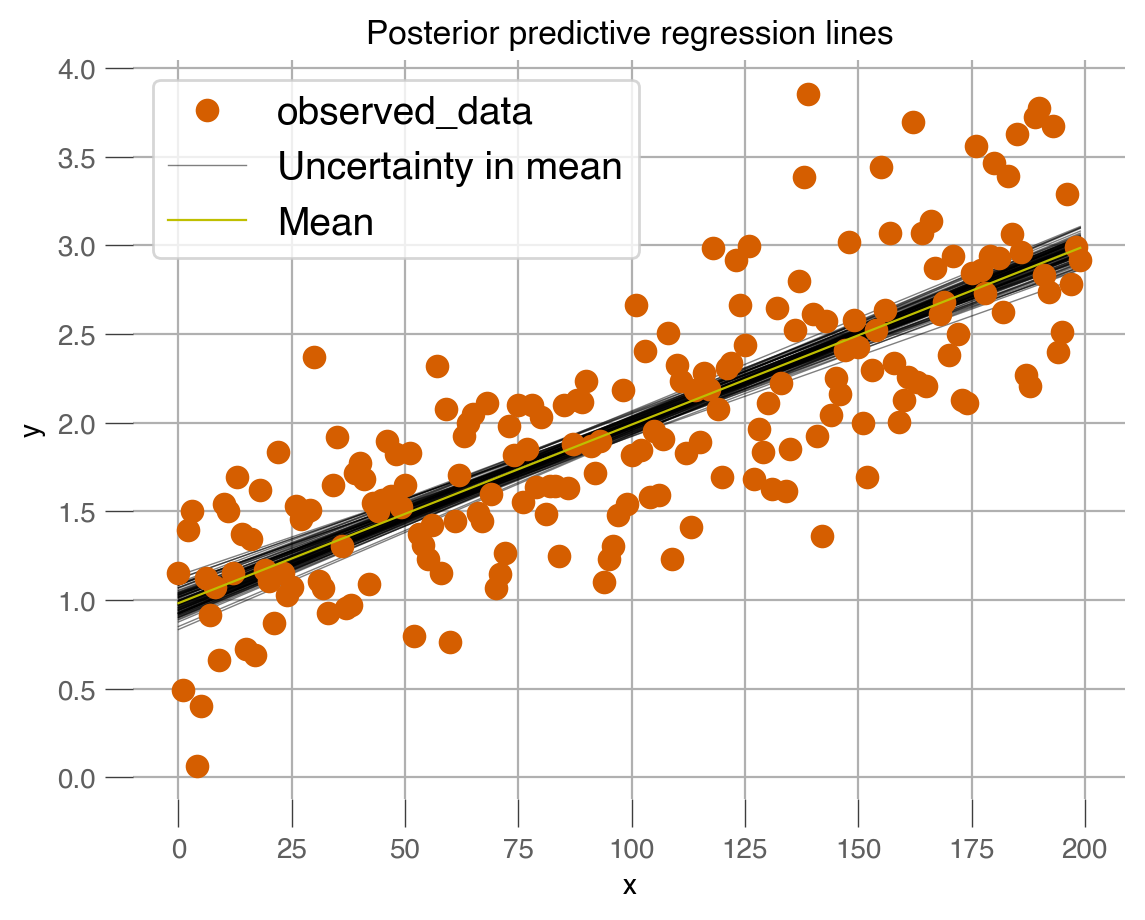

In [10]:
az.plot_lm(idata=idata, y="y", num_samples=100, y_model="y_model")
plt.title("Posterior predictive regression lines")
plt.xlabel("x");

Come abbiamo già osservato in precedenza, le rette di regressione stimate si avvicinano notevolmente alla vera retta di regressione. Tuttavia, dato che stiamo lavorando con un campione di dati e non con l'intera popolazione, le stime dei parametri della retta di regressione, quali intercetta e pendenza, sono soggette a un certo grado di incertezza. Questa incertezza non è un difetto, ma una rappresentazione naturale dell'informazione limitata che abbiamo a disposizione, e nel grafico è visualizzata attraverso la variabilità delle rette di regressione.

## Watermark

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Aug 26 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

matplotlib: 3.7.1
seaborn   : 0.12.2
xarray    : 2023.8.0
arviz     : 0.16.1
pandas    : 2.0.3
numpy     : 1.25.2
bambi     : 0.12.0

Watermark: 2.4.3

